In [ ]:
!pip install gymnasium[atari] --quiet
!pip install gymnasium --quiet
!pip install -U gymnasium[atari] --quiet
!pip install imageio_ffmpeg --quiet
!pip install npy_append_array --quiet
!pip install pyTelegramBotAPI --quiet
!pip install gymnasium[accept-rom-license] --quiet
!pip install gymnasium[box2d] --quiet

In [3]:
import numpy as np 

class ExperienceReplayBuffer: 
    def __init__(self, max_memory, input_shape, n_actions): 
        self.mem_size = max_memory
        self.mem_counter = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_experience(self, state, action, reward, next_state, done): 
        index = self.mem_counter % self.mem_size 

        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_counter += 1
        

    def sample_experience(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        batch_index = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch_index]
        next_states = self.new_state_memory[batch_index]
        rewards = self.reward_memory[batch_index]
        actions = self.action_memory[batch_index]
        terminal = self.terminal_memory[batch_index]

        return states, actions, rewards, next_states, terminal


In [15]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D, Input, Add, Lambda
from tensorflow.keras import backend as K


class DeepQNetwork2D(keras.Model):
    def __init__(self, input_dims, n_actions):
        super(DeepQNetwork2D, self).__init__()
     #   self.fc1 = Dense(64, activation='relu')
        self.fc1 = Dense(64, activation='relu')
        self.fc2 = Dense(64, activation='relu')
        
        self.value_output = Dense(1)
        self.advantage_output = Dense(n_actions)
        self.add = Add()

    def call(self, state):

        x = self.fc1(state)
        x = self.fc2(x)
        
        value_output = self.value_output(x)
        advantage_output = self.advantage_output(x)
        output = self.add([value_output, advantage_output])
        return output


class DeepQNetwork3D(keras.Model): 
    def __init__(self, input_dims, n_actions):
        super(DeepQNetwork3D, self).__init__()

        self.conv1 = Conv2D(64, 8, strides=(4, 4), activation='relu', data_format="channels_first", input_shape=input_dims)
        self.conv2 = Conv2D(64, 4, strides=(2, 2), activation='relu', data_format="channels_first")
        self.conv3 = Conv2D(32, 3, strides=(1, 1), activation='relu', data_format="channels_first")
        self.flatten = Flatten()

        self.fc2 = Dense(128, activation='relu')
        self.value_output = Dense(1)
        self.advantage_output = Dense(n_actions)
        self.add = Add()

    def call(self, state):

        x = self.conv1(state)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        
        x = self.fc2(x)
        value_output = self.value_output(x)
        advantage_output = self.advantage_output(x)
        output = self.add([value_output, advantage_output])
        return output

In [16]:
import numpy as np

def epsilon_greedy_policy(q_val_network, observation, action_space, epsilon):
        if np.random.random() > epsilon:
            state = tf.convert_to_tensor([observation])
            actions = q_val_network.predict(state, verbose=0)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        else:
            action = np.random.choice(action_space)
        return action


def greedy_policy(observation, q_val_network, action_space): 
    state = tf.convert_to_tensor([observation])
    actions = q_val_network(state)
    action = tf.math.argmax(actions, axis=1).numpy()[0]
    return action


In [65]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam

#https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code/blob/master/DQN/tf2/agent.py
class Agent: 
    def __init__(self, agent_params):
        # Parameters
        self.gamma = agent_params.get("gamma")
        self.lr = agent_params.get("lr")
        self.input_dims = agent_params.get("input_dims")
        self.batch_size = agent_params.get("batch_size")
        self.replace_target_weight_counter = agent_params.get("replace")
        self.algo = agent_params.get("algo")
        self.env_name = agent_params.get("env_name")
        self.chkpt_dir = agent_params.get("chkpt_dir")
        self.n_actions = agent_params.get("n_actions")
        self.action_space = agent_params.get('actions')
        self.soft_update = agent_params.get("soft_update")
        self.TAU = agent_params.get("TAU")
        
        self.eps = agent_params.get("eps")
        self.min_eps = agent_params.get("min_eps")
        self.eps_decay_rate = agent_params.get("eps_decay_rate")
        
        self.learn_step_counter = 0
        self.fname = self.chkpt_dir + self.env_name + '_' + self.algo + '_'
        self.mem_size = agent_params.get("mem_size")

        # networks and replaybuffer
        self.memory = ExperienceReplayBuffer(self.mem_size, self.input_dims, self.n_actions)
        self.q_value_network = DeepQNetwork3D(self.input_dims, self.n_actions) if len(self.input_dims) > 2 else \
                                                                                    DeepQNetwork2D(self.input_dims, self.n_actions)
        self.q_value_network.compile(optimizer=Adam(learning_rate=self.lr))
        self.target_q_network = DeepQNetwork3D(self.input_dims, self.n_actions) if len(self.input_dims) > 2 else \
                                                                                    DeepQNetwork2D(self.input_dims, self.n_actions)
        self.target_q_network.compile(optimizer=Adam(learning_rate=self.lr))

    def save_models(self):
        self.q_value_network.save(self.fname+'q_value')
        self.target_q_network.save(self.fname+'target_q')
        print('... models saved successfully ...')

    def load_models(self):
        self.q_value_network = keras.models.load_model(self.fname+'q_value')
        self.target_q_network = keras.models.load_model(self.fname+'target_q')
        print('... models loaded successfully ...')

    def store_experience(self, state, action, reward, state_, done):
        self.memory.store_experience(state, action, reward, state_, done)

    def sample_experience(self):
        state, action, reward, new_state, done = \
                                  self.memory.sample_experience(self.batch_size)
        states = tf.convert_to_tensor(state)
        rewards = tf.convert_to_tensor(reward)
        dones = tf.convert_to_tensor(done)
        actions = tf.convert_to_tensor(action, dtype=tf.int32)
        states_ = tf.convert_to_tensor(new_state)
        return states, actions, rewards, states_, dones

    def choose_action(self, observation):
        if np.random.random() > self.eps:
            state = tf.convert_to_tensor([observation])
            actions = self.q_value_network(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        else:
            action = np.random.choice(self.action_space)
        return action

    def replace_target_network(self):
        if not self.soft_update:
            self.target_q_network.set_weights(self.q_value_network.get_weights())
            return
        else: 
            q_model_theta = self.q_value_network.get_weights()
            target_model_theta = self.target_q_network.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_q_network.set_weights(target_model_theta)

    def decrement_epsilon(self): 
        self.eps -= self.eps_decay_rate
        self.eps = max(self.eps, self.min_eps)

    def learn(self):
        if self.memory.mem_counter < self.batch_size:
            return

        self.replace_target_network()
        
        states, actions, rewards, states_, dones = self.sample_experience()
        indices = tf.range(self.batch_size, dtype=tf.int32)
        action_indices = tf.stack([indices, actions], axis=1)

        with tf.GradientTape() as tape:
        
            q_pred = tf.gather_nd(self.q_value_network(states), indices=action_indices)
            q_next = self.target_q_network(states_)
            q_eval = self.q_value_network(states_)

            max_actions = tf.math.argmax(q_eval, axis=1, output_type=tf.int32)
            max_action_idx = tf.stack([indices, max_actions], axis=1)

            q_target = rewards + \
                self.gamma*tf.gather_nd(q_next, indices=max_action_idx) *\
                (1 - dones.numpy())

            loss = keras.losses.MSE(q_pred, q_target)
            
        params = self.q_value_network.trainable_variables
        grads = tape.gradient(loss, params)
        self.q_value_network.optimizer.apply_gradients(zip(grads, params))
        
        self.learn_step_counter += 1
        self.decrement_epsilon()       

        return self.eps

In [51]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from gymnasium.wrappers import *


def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(scores, epsilons, filename, lines=None):
    x = [_ for _ in range(len(scores))]
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)


def make_env(env_name, video_file_name, episode_freq_fo_video): 
    env = gym.make(env_name, render_mode="rgb_array")
    
    if len(env.observation_space.shape) >= 3: 
        #env = AtariPreprocessing(env, 10, 4, 84, False, True)
        env = ResizeObservation(env, 84)
        env = GrayScaleObservation(env, keep_dim=False)
        env = FrameStack(env, 4, lz4_compress=False)
        env = NormalizeObservation(env)

    return env

In [52]:
class Writer:
    def __init__(self, fname): 
        self.fname = fname 

    def write_to_file(self, content): 
        with open(self.fname, "a") as file: 
            file.write(content + "\n")

    def read_file(self, fname):
        with open(fname, "r") as file: 
            return file.read()
            

In [53]:
import time
from telebot import TeleBot
import datetime
import telebot

token = "6238487424:AAG0jRhvbiVa90qUcf2fAirQr_-quPMs7cU"
chat_id = "1055055706"
bot = TeleBot(token=token) 

def telegram_send(message, bot):
    chat_id = "1055055706"
    bot.send_message(chat_id=chat_id, text=message)

def welcome_msg(multi_step, double_dqn, dueling):
    st = 'Hi! Starting learning with DQN Multi-step = %d, Double DQN = %r, Dueling DQN = %r' % (multi_step, double_dqn, dueling)
    telegram_send(st, bot)
    
def info_msg(episode, max_episode, reward, best_score, loss): 
    st = f"Current Episode: {episode}, Current Reward: {reward}, Max Episode: {max_episode}, Best Score: {best_score}, loss: {loss}"
    telegram_send(st, bot)

def end_msg(learning_time):
    st = 'Finished! Learning time: ' + str(datetime.timedelta(seconds=int(learning_time)))
    telegram_send(st, bot)
    print(st)


In [54]:
import numpy as np 
import imageio


class RecordVideo: 
    
    def __init__(self, prefix_fname,  out_directory="videos/", fps=10): 
        self.prefix_fname = prefix_fname
        self.out_directory = out_directory
        self.fps = fps
        self.images = []
        
    def add_image(self, image): 
        self.images.append(image)
    
    def save(self, episode_no): 
        name = self.out_directory + self.prefix_fname + "_" + str(episode_no) + ".mp4"
        imageio.mimsave(name, [np.array(img) for i, img in enumerate(self.images)], fps=self.fps)
        self.images = []

In [55]:
from npy_append_array import NpyAppendArray
import numpy as np

class Trainer:   
    def __init__(self, env, trainer_params): 
       
        self.env = env 
        self.noe = trainer_params.get("noe")
        self.max_steps = trainer_params.get("max_steps")
       
        self.eps_decay_rate = trainer_params.get("eps_decay_rate")
        self.action_space = trainer_params.get("action_space")
        self.is_tg = trainer_params.get("is_tg")
        self.tg_bot_freq_epi = trainer_params.get("tg_bot_freq_epi")
        self.record = trainer_params.get("record")
        self.agent_params = {
                        "gamma":  trainer_params.get("gamma"), 
                        "lr":  trainer_params.get("lr"), 
                        "input_dims":  trainer_params.get("input_dims"),
                        "mem_size" :  trainer_params.get("mem_size"),
                        "batch_size" :  trainer_params.get("batch_size"),
                        "replace" :  trainer_params.get("replace"),
                        "algo" :  trainer_params.get("algo"),
                        "env_name" :  trainer_params.get("env_name"),
                        "n_actions" :  trainer_params.get("n_actions"),
                        "chkpt_dir":  trainer_params.get("chkpt_dir"),
                        "actions":  trainer_params.get("actions"),
                        "eps": trainer_params.get("eps"),
                        "min_eps": trainer_params.get("min_eps"),
                        "eps_decay_rate": trainer_params.get("eps_decay_rate"),
                        "soft_update": trainer_params.get("soft_update"),
                        "TAU": trainer_params.get("TAU")
                        
                    }
        
        self.agent = Agent(self.agent_params)
        self.checkpoint = trainer_params.get("checkpoint")
        
        self.writer = Writer("model_training_results.txt")
        self.recorder = RecordVideo(trainer_params.get("video_prefix"), "videos/", 20)
        
        self.target_score = trainer_params.get("target_score")

    def train_rl_model(self): 
        episode_rewards = []
        epsilon_history = []
        avg_rewards = []
        best_reward = float("-inf")

        if self.checkpoint:
            self.agent.load_models()

        for episode in range(self.noe): 
            n_steps = 0 
            episodic_loss = 0
            state = self.env.reset()
            reward = 0 
            
            if self.record and episode%100==0: 
                img = self.env.render()
                self.recorder.add_image(img)

            for step in range(self.max_steps): 
                
                if self.record and episode%100==0: 
                    img = self.env.render()
                    self.recorder.add_image(img)

                if type(state) == tuple: 
                    state = state[0]
                state = state

                action = self.agent.choose_action(state)

                next_info = self.env.step(action)
                next_state, reward_prob, terminated, truncated, _ = next_info
                done = truncated or terminated
                reward += reward_prob

                self.agent.store_experience(state, action, reward_prob, next_state, done)
                eps = self.agent.learn()

                state = next_state
                n_steps += 1 
               
                
                if done: 
                    break

            epsilon_history.append(eps)
            episode_rewards.append(reward)
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards.append(avg_reward)

            result = f"Episode: {episode}, Epsilon: {eps}, Steps: {n_steps}, Reward: {reward}, Best reward: {best_reward}, Avg reward: {avg_reward}"
            self.writer.write_to_file(result)
            print(result)
            
            # Saving Best Model
            if reward > best_reward: 
                best_reward = reward
                self.agent.save_models()
            
            # video Recorder
            if episode % 100 ==0:
                self.recorder.save(episode)
                
          # Telegram bot
            if self.is_tg and episode % self.tg_bot_freq_epi == 0: 
                info_msg(episode+1, self.noe, reward, best_reward, "d")
                
         # Eatly Stopping
            if episode > 100 and np.mean(episode_rewards[-100:]) >= self.target_score: 
                break
                
                
        return episode_rewards, epsilon_history, avg_rewards, best_reward

In [ ]:
import gymnasium as gym
import time
import signal
import time
import sys
import pickle
import os 

if not os.path.exists("videos"): 
    os.mkdir("videos")
    
if not os.path.exists("test_videos"):
    os.mkdir("test_videos")

env = make_env("ALE/Pong-v5", "videos/", 50)
record = True
action_space = [_ for _ in range(env.action_space.n)]

trainer_params = {
    "noe": 1000, 
    "max_steps": int(1e6),
    "max_eps": 1,
    "min_eps": 0.1,
    "eps_decay_rate": 1e-4,
    "eps": 1,
    "action_space": action_space,
    "is_tg": True,
    "tg_bot_freq_epi": 10,
    "record": record,
    "gamma": 0.99, 
    "lr": 0.0001, 
    "input_dims": env.observation_space.shape,
    "mem_size" : 100000,
    "batch_size" : 32,
    "replace" : 500,
    "algo" : "dueling_ddqn",
    "env_name" : "pong",
    "n_actions" : len(action_space),
    "chkpt_dir": "models/pong/",
    "actions": action_space,
    "target_score": 200,
    "video_prefix": "dueling_ddqn",
    "checkpoint": False,
    "TAU": 0.01,
    "soft_update": True
}

if __name__ == "__main__": 
    
    try: 
        manage_memory()
       
        trainer = Trainer(env, trainer_params)
        episode_rewards, epsilon_history, avg_rewards, best_reward = trainer.train_rl_model()
        
        with open("dueling_ddqn_episode_rewards.obj", "wb") as f: 
            pickle.dump(episode_rewards, f)
        
        with open("dueling_ddqn_epsilon_history.obj", "wb") as f: 
            pickle.dump(epsilon_history, f)
        
        with open("dueling_ddqn_avg_rewards.obj", "wb") as f: 
            pickle.dump(avg_rewards, f)
            
        plot_learning_curve(episode_rewards, epsilon_history, "dueling_ddqn")
        
    except Exception as error: 
        raise error


/opt/conda/lib/python3.7/site-packages/gymnasium/utils/passive_env_checker.py:365: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."


Episode: 0, Epsilon: 0.8952000000000115, Steps: 1079, Reward: -20.0, Best reward: -inf, Avg reward: -20.0
... models saved successfully ...
Episode: 1, Epsilon: 0.8081000000000211, Steps: 871, Reward: -20.0, Best reward: -20.0, Avg reward: -20.0
Episode: 2, Epsilon: 0.7153000000000314, Steps: 928, Reward: -20.0, Best reward: -20.0, Avg reward: -20.0
Episode: 3, Epsilon: 0.6361000000000401, Steps: 792, Reward: -21.0, Best reward: -20.0, Avg reward: -20.25
Episode: 4, Epsilon: 0.5348000000000512, Steps: 1013, Reward: -20.0, Best reward: -20.0, Avg reward: -20.2
Episode: 5, Epsilon: 0.4250000000000633, Steps: 1098, Reward: -19.0, Best reward: -20.0, Avg reward: -20.0
... models saved successfully ...
Episode: 6, Epsilon: 0.3199000000000749, Steps: 1051, Reward: -21.0, Best reward: -19.0, Avg reward: -20.142857142857142
Episode: 7, Epsilon: 0.22020000000008588, Steps: 997, Reward: -20.0, Best reward: -19.0, Avg reward: -20.125
Episode: 8, Epsilon: 0.1087000000000959, Steps: 1115, Reward: -

(8,)
Episode: 0, Epsilon: 0.9993900000000028, Steps: 92, Reward: -198.10629434716412, Best reward: -inf, Avg reward: -198.10629434716412
... models saved successfully ...


[swscaler @ 0x6bdc200] Warning: data is not aligned! This can lead to a speed loss


Episode: 1, Epsilon: 0.9983000000000077, Steps: 109, Reward: -149.1094992001238, Best reward: -198.10629434716412, Avg reward: -173.60789677364397
... models saved successfully ...
Episode: 2, Epsilon: 0.9976400000000107, Steps: 66, Reward: -92.84819444061297, Best reward: -149.1094992001238, Avg reward: -146.687995995967
... models saved successfully ...
Episode: 3, Epsilon: 0.9966900000000151, Steps: 95, Reward: -125.65753303710063, Best reward: -92.84819444061297, Avg reward: -141.4303802562504
Episode: 4, Epsilon: 0.9954900000000205, Steps: 120, Reward: -103.58238667669764, Best reward: -92.84819444061297, Avg reward: -133.86078154033984
Episode: 5, Epsilon: 0.9946100000000245, Steps: 88, Reward: -4.337289716042434, Best reward: -92.84819444061297, Avg reward: -112.27353290295694
... models saved successfully ...
Episode: 6, Epsilon: 0.993200000000031, Steps: 141, Reward: -192.3757261214223, Best reward: -4.337289716042434, Avg reward: -123.7167033627377
Episode: 7, Epsilon: 0.9922

[swscaler @ 0x609c200] Warning: data is not aligned! This can lead to a speed loss


Episode: 101, Epsilon: 0.9021300000004454, Steps: 94, Reward: -154.98215298161864, Best reward: 39.325510506456, Avg reward: -154.38575528336654
Episode: 102, Epsilon: 0.9010100000004505, Steps: 112, Reward: -90.50288147013671, Best reward: 39.325510506456, Avg reward: -154.36230215366177
Episode: 103, Epsilon: 0.8996200000004568, Steps: 139, Reward: -157.493241440504, Best reward: 39.325510506456, Avg reward: -154.6806592376958
Episode: 104, Epsilon: 0.8988700000004602, Steps: 75, Reward: -80.68435887408681, Best reward: 39.325510506456, Avg reward: -154.4516789596697
Episode: 105, Epsilon: 0.8979300000004645, Steps: 94, Reward: 29.631426711218637, Best reward: 39.325510506456, Avg reward: -154.11199179539707
Episode: 106, Epsilon: 0.8972000000004678, Steps: 73, Reward: -83.21059894135695, Best reward: 39.325510506456, Avg reward: -153.02034052359645
Episode: 107, Epsilon: 0.8962500000004722, Steps: 95, Reward: -109.35737775842104, Best reward: 39.325510506456, Avg reward: -152.334530

[swscaler @ 0x5bc9200] Warning: data is not aligned! This can lead to a speed loss


Episode: 201, Epsilon: 0.8061100000008824, Steps: 113, Reward: -132.24123662751603, Best reward: 39.325510506456, Avg reward: -109.28892236118672
Episode: 202, Epsilon: 0.8055000000008852, Steps: 61, Reward: -109.98292078789609, Best reward: 39.325510506456, Avg reward: -109.48372275436432
Episode: 203, Epsilon: 0.8041700000008912, Steps: 133, Reward: -111.17789911640138, Best reward: 39.325510506456, Avg reward: -109.02056933112328
Episode: 204, Epsilon: 0.8031400000008959, Steps: 103, Reward: -132.59441206185068, Best reward: 39.325510506456, Avg reward: -109.53966986300092
Episode: 205, Epsilon: 0.8021500000009004, Steps: 99, Reward: -34.65211703473362, Best reward: 39.325510506456, Avg reward: -110.18250530046043
Episode: 206, Epsilon: 0.8011900000009048, Steps: 96, Reward: -54.838139852383875, Best reward: 39.325510506456, Avg reward: -109.89878070957072
Episode: 207, Epsilon: 0.8000200000009101, Steps: 117, Reward: -116.96571014482353, Best reward: 39.325510506456, Avg reward: -1

[swscaler @ 0x60b1200] Warning: data is not aligned! This can lead to a speed loss


Episode: 301, Epsilon: 0.6942600000013914, Steps: 160, Reward: -98.10100984025878, Best reward: 39.325510506456, Avg reward: -92.35576887666792
Episode: 302, Epsilon: 0.6931600000013964, Steps: 110, Reward: -105.69498399552619, Best reward: 39.325510506456, Avg reward: -92.31288950874425
Episode: 303, Epsilon: 0.6915500000014038, Steps: 161, Reward: -67.31028203827564, Best reward: 39.325510506456, Avg reward: -91.87421333796297
Episode: 304, Epsilon: 0.689960000001411, Steps: 159, Reward: -76.17310555026445, Best reward: 39.325510506456, Avg reward: -91.31000027284708
Episode: 305, Epsilon: 0.6880500000014197, Steps: 191, Reward: -38.21105949425414, Best reward: 39.325510506456, Avg reward: -91.34558969744228
Episode: 306, Epsilon: 0.6868000000014254, Steps: 125, Reward: -204.35244092830197, Best reward: 39.325510506456, Avg reward: -92.84073270820147
Episode: 307, Epsilon: 0.6854800000014314, Steps: 132, Reward: -83.19172494446077, Best reward: 39.325510506456, Avg reward: -92.502992

[swscaler @ 0x6e35200] Warning: data is not aligned! This can lead to a speed loss


Episode: 401, Epsilon: 0.5216200000021771, Steps: 356, Reward: -43.781542908627046, Best reward: 39.325510506456, Avg reward: -76.89037454182866
Episode: 402, Epsilon: 0.5206700000021814, Steps: 95, Reward: -40.47068482949511, Best reward: 39.325510506456, Avg reward: -76.23813155016836
Episode: 403, Epsilon: 0.5183700000021919, Steps: 230, Reward: -85.5257587031957, Best reward: 39.325510506456, Avg reward: -76.42028631681757
Episode: 404, Epsilon: 0.5172000000021972, Steps: 117, Reward: -36.81970998127487, Best reward: 39.325510506456, Avg reward: -76.02675236112768
Episode: 405, Epsilon: 0.5137600000022129, Steps: 344, Reward: -24.360595315315706, Best reward: 39.325510506456, Avg reward: -75.88824771933828
Episode: 406, Epsilon: 0.5100900000022296, Steps: 367, Reward: -30.711949763246267, Best reward: 39.325510506456, Avg reward: -74.15184280768773
Episode: 407, Epsilon: 0.5000900000022751, Steps: 1000, Reward: -50.106044951855466, Best reward: 39.325510506456, Avg reward: -73.8209

[swscaler @ 0x67dd200] Warning: data is not aligned! This can lead to a speed loss


Episode: 501, Epsilon: 0.1, Steps: 982, Reward: 151.04615987924544, Best reward: 225.59688076426494, Avg reward: -19.498023461386662
Episode: 502, Epsilon: 0.1, Steps: 788, Reward: 159.46188484740247, Best reward: 225.59688076426494, Avg reward: -17.498697764617688
Episode: 503, Epsilon: 0.1, Steps: 404, Reward: 207.34565549410263, Best reward: 225.59688076426494, Avg reward: -14.569983622644699
Episode: 504, Epsilon: 0.1, Steps: 594, Reward: 261.5612155776386, Best reward: 225.59688076426494, Avg reward: -11.586174367055566
... models saved successfully ...
Episode: 505, Epsilon: 0.1, Steps: 422, Reward: 266.89991663490946, Best reward: 261.5612155776386, Avg reward: -8.673569247553312
... models saved successfully ...
Episode: 506, Epsilon: 0.1, Steps: 818, Reward: 206.47020464572853, Best reward: 266.89991663490946, Avg reward: -6.301747703463564
Episode: 507, Epsilon: 0.1, Steps: 478, Reward: 231.19611775979425, Best reward: 266.89991663490946, Avg reward: -3.488726076347067
Episod

[swscaler @ 0x5708200] Warning: data is not aligned! This can lead to a speed loss


Episode: 601, Epsilon: 0.1, Steps: 120, Reward: -10.737981662268098, Best reward: 302.2446958437599, Avg reward: 191.44756870113008
Episode: 602, Epsilon: 0.1, Steps: 454, Reward: 207.30590539115917, Best reward: 302.2446958437599, Avg reward: 191.92600890656763
Episode: 603, Epsilon: 0.1, Steps: 301, Reward: 261.47229564991846, Best reward: 302.2446958437599, Avg reward: 192.46727530812578
Episode: 604, Epsilon: 0.1, Steps: 373, Reward: 245.34189248904002, Best reward: 302.2446958437599, Avg reward: 192.30508207723975
Episode: 605, Epsilon: 0.1, Steps: 318, Reward: -45.56215537188048, Best reward: 302.2446958437599, Avg reward: 189.18046135717188
Episode: 606, Epsilon: 0.1, Steps: 521, Reward: 243.54906258787545, Best reward: 302.2446958437599, Avg reward: 189.5512499365933
Episode: 607, Epsilon: 0.1, Steps: 483, Reward: 164.29829348499334, Best reward: 302.2446958437599, Avg reward: 188.88227169384533
Episode: 608, Epsilon: 0.1, Steps: 629, Reward: 228.41515741682076, Best reward: 30

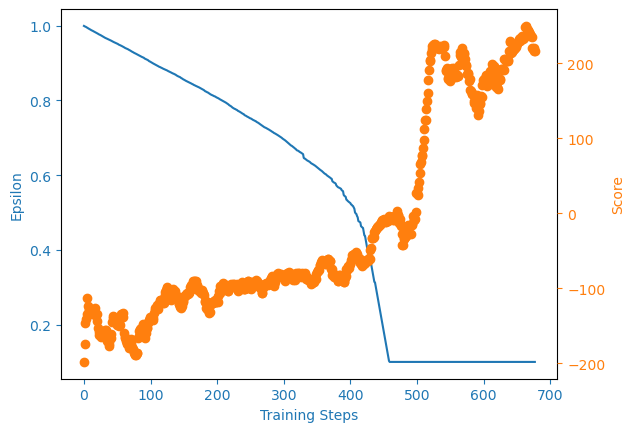

In [67]:
import gymnasium as gym
import time
import signal
import time
import sys
import pickle

env = make_env("LunarLander-v2", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]
record = True
print( env.observation_space.shape)

trainer_params = {
    "noe": 1000, 
    "max_steps": 10000,
    "max_eps": 1,
    "min_eps": 0.1,
    "eps_decay_rate": 1e-5,
    "eps": 1,
    "action_space": action_space,
    "is_tg": True,
    "tg_bot_freq_epi": 10,
    "record": record,
    "gamma": 0.99, 
    "lr": 0.001, 
    "input_dims": env.observation_space.shape,
    "mem_size" : 100000,
    "batch_size" : 32,
    "replace" : 500,
    "algo" : "dueling_dqn",
    "env_name" : "lunarlander",
    "n_actions" : len(action_space),
    "chkpt_dir": "tmp/dueling_dqn/",
    "actions": action_space,
    "target_score": 200,
    "video_prefix": "dueling_dqn",
    "checkpoint": False,
    "TAU": 0.01,
    "soft_update": True
}

    
if __name__ == "__main__": 
    
    try: 
        manage_memory()
       
        trainer = Trainer(env, trainer_params)
        episode_rewards, epsilon_history, avg_rewards, best_reward = trainer.train_rl_model()
        
        with open("dueling_dqn_episode_rewards.obj", "wb") as f: 
            pickle.dump(episode_rewards, f)
        
        with open("dueling_dqn_epsilon_history.obj", "wb") as f: 
            pickle.dump(epsilon_history, f)
        
        with open("dueling_dqn_avg_rewards.obj", "wb") as f: 
            pickle.dump(avg_rewards, f)
            
        plot_learning_curve(episode_rewards, epsilon_history, "dueling_dqn")
        
    except Exception as error: 
        raise error
        
   # eval_model(env, "keras model", "videos/", fps=10)


In [80]:
import random 
import imageio
import tensorflow as tf 


class Eval: 

    def __init__(self, env, model_path, action_space, number_of_episode=50, test_video_path="test_videos/"):
        self.env = env 
        self.model = tf.keras.models.load_model(model_path)
        print(self.model)
        self.recorder = RecordVideo('dueling_ddqn', test_video_path, 15)
        self.number_of_episode = number_of_episode
        self.action_space = action_space
        
    def test(self): 
        rewards = []
        steps = []
        for episode in range(self.number_of_episode): 
            done = False
            reward = 0
            step = 0
            state = env.reset(seed=random.randint(0,500))
            if episode % 5 == 0: 
                img = env.render()
                self.recorder.add_image(img) 

            while not done:
                if type(state) == tuple: 
                    state = state[0]
                    
                action =  greedy_policy(state, self.model, self.action_space)
                state, reward_prob, terminated, truncated, _ = env.step(action)
                done = terminated or truncated 
                reward += reward_prob
                step += 1 
                if episode % 5 == 0:
                    img = env.render()
                    self.recorder.add_image(img)
            
            rewards.append(reward)
            steps.append(step)
            self.recorder.save(episode) if episode % 5 == 0 else None
        
        return rewards, steps                                                                                                                                                        


In [ ]:
env = make_env("LunarLander-v2", "test_videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]
model_path = "models/pong/pong_dueling_ddqn_q_value"

eval = Eval(env, model_path, action_space, 10)